# GRIP Task 2

## Computer Vision and IOT

### Name : SAJAL SINGH

Color Detection in images.

### 1. Importing Libraries

In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import KMeans
from skimage.color import rgb2lab, deltaE_cie76

### 2. Reading Image

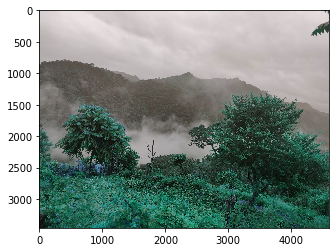

In [13]:
image = cv2.imread('\\Users\\Desktop\\sample_image.jpg')
plt.imshow(image)
plt.show()

### 3. Checking Type and Shape of image Data

In [14]:
print("The type of this input is {}".format(type(image)))
print("Shape: {}".format(image.shape))

The type of this input is <class 'numpy.ndarray'>
Shape: (3456, 4608, 3)


### NOTE
We can see that the image has different colors as compared to the original image. This is because by default OpenCV reads the images in the color order "Blue-Green-RED" i.e. BGR. Thus, we need to convert it into "RED GREEN BLUE" i.e. RGB.

### 4. Converting BGR-To-RGB

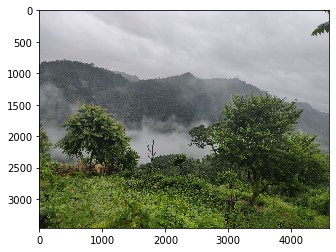

In [15]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

### NOTE
Now we need to convert RGB image to grayscale becuase in RGB image we have 3 channel so computer need more time and memory to understand what's inside image but with grayscale we only left with 2d array so it's easy for computer to understand.

### 5. Converting Image to GrayScale

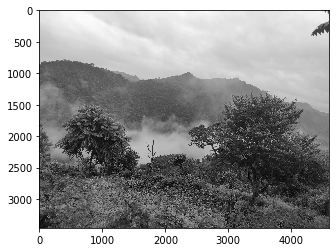

In [16]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image, cmap='gray')
plt.show()

### Note
We need to resize the image to a certain size becuase we have images that are huge in size with different dimensions.

### 6. Resizing Images

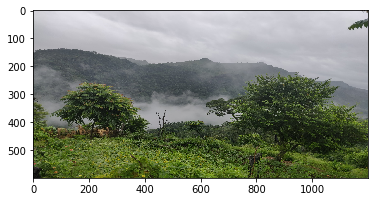

In [17]:
resized_image = cv2.resize(image, (1200, 600))
plt.imshow(resized_image)
plt.show()

### 7. Let us start color Identification.

In [18]:
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

### Note
KMeans expects flattened array as input during its fit method. Thus, we need to reshape the image using numpy. Then, we can apply KMeans to first fit and then predict on the image to get the results. Then, the cluster colors are identified an arranged in the correct order. We plot the colors as a pie chart. I have combined all the steps in two method.

### 8. Defining method for getting images & Conversion from BGR-TO-RGB

In [19]:
def get_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

### 9. Defining method along with K_Means Algorithm
First we need to resize data into same size, then converting into array on which i fitted model.

In [23]:
def get_colors(image, number_of_colors, show_chart): 
    
    modified_image = cv2.resize(image, (600, 400), interpolation = cv2.INTER_AREA)
    modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)
    
    clf = KMeans(n_clusters = number_of_colors)
    labels = clf.fit_predict(modified_image)
    
    counts = Counter(labels)
    counts = dict(sorted(counts.items()))
    
    center_colors = clf.cluster_centers_
    ordered_colors = [center_colors[i] for i in counts.keys()]
    
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in counts.keys()]
    
    if (show_chart):
        plt.figure(figsize = (8, 6))
        plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
    
    return rgb_colors

### 10. Calling Above Two Functions inside each other

[array([84.03623649, 90.89045404, 92.15943387]),
 array([206.35499092, 206.06052014, 213.51670285]),
 array([30.15875912, 38.58081335, 21.13138686]),
 array([78.57472512, 96.28895581, 38.58218363]),
 array([120.90729562, 125.47736288, 125.37267161]),
 array([179.20276243, 179.79679558, 186.22151934]),
 array([54.5297528 , 67.3393761 , 34.04823426]),
 array([110.05398728, 125.53573414,  56.79776391])]

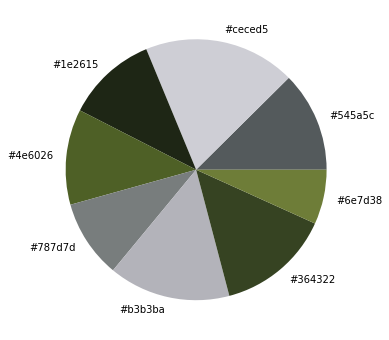

In [25]:
get_colors(get_image('\\Users\\Desktop\\sample_image.jpg'), 8, True)

### 11. Search images using Color
From the model above, we can extract the major colors. This create the opportunity to search for images based on certain colors. We can select a color and if it's hex matches or is close to the hex of the major colors of the image, we say it's a match. We first get all the images and store them in the "images" variable.

In [39]:
IMAGE_DIRECTORY = '\\Users\\Desktop\\Spark-foundation-internship-tasks-computer-vision--main\\Task 2\\images'

COLORS = {'GREEN': [0, 128, 0],'BLUE': [0, 0, 128],'YELLOW': [255, 255, 0]}

images = []

for file in os.listdir(IMAGE_DIRECTORY):
    if not file.startswith('.'):
        images.append(get_image(os.path.join(IMAGE_DIRECTORY, file)))

### 12. Visualization of Data

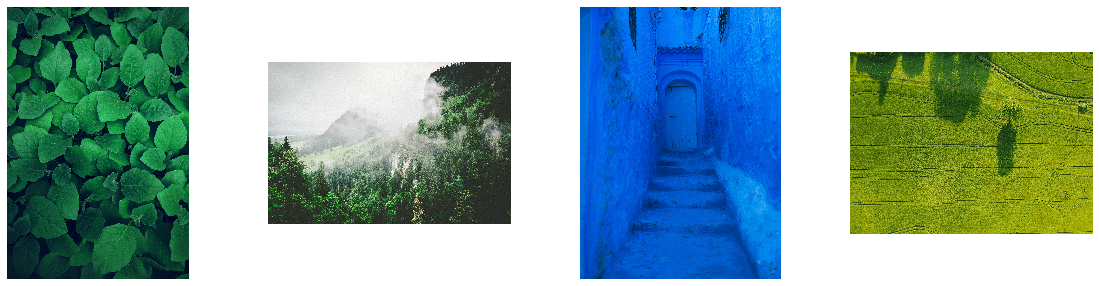

In [40]:
plt.figure(figsize=(20, 5))
for i in range(len(images)):
    plt.subplot(1, len(images), i+1)
    plt.imshow(images[i])
    plt.axis('off')

### 13. Function for finding matches by using top 10 colors in images
I define the function below. I will try to match with the top 10 colors of the image. It is highly possible that there will be no extact match for the hex codes, thus we calculate the similarity between the chosen color and the colors of the image. We keep a threshold value such that if the difference between the chosen color and any of the selected colors is less than that threshold, we declare it as a match. Hex values or RGB values cannot be directly compared so I first convert them to a device independant and color uniform space. We use "RGB2LAB" to convert the values and then find the difference using "deltaE_cie76". The method calculates the difference between all top 5 colors of the image and the selected color and if atleast one is below the threshold, we show the image.

In [41]:
def match_image_by_color(image, color, threshold = 60, number_of_colors = 10): 
    
    image_colors = get_colors(image, number_of_colors, False)
    selected_color = rgb2lab(np.uint8(np.asarray([[color]])))

    select_image = False
    
    for i in range(number_of_colors):
        
        curr_color = rgb2lab(np.uint8(np.asarray([[image_colors[i]]])))
        diff = deltaE_cie76(selected_color, curr_color)
        
        if (diff < threshold):
            select_image = True
    
    return select_image

### 14. Function for selection of images (Match/Mismatch)
I call the above method for all the images in our set and show relevant images out of the same that approximately match our selected color.

In [42]:
def show_selected_images(images, color, threshold, colors_to_match):
    index = 1
    
    for i in range(len(images)):
        selected = match_image_by_color(images[i],
                                        color,
                                        threshold,
                                        colors_to_match)
        if (selected):
            plt.subplot(1, 5, index)
            plt.imshow(images[i])
            plt.axis('off')
            index += 1

### 15. Calling above methods and visualizing results
Finding GREEN COLOR

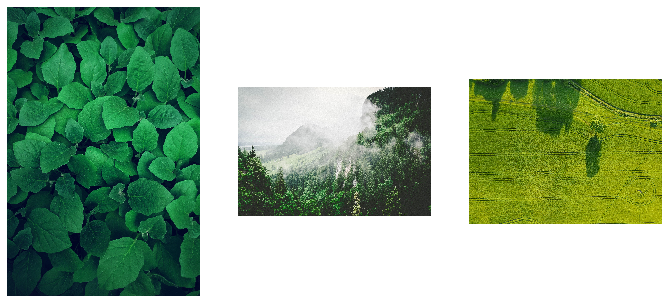

In [43]:
plt.figure(figsize = (20, 8))
show_selected_images(images, COLORS['GREEN'], 60, 5)

FINDING BLUE COLOR

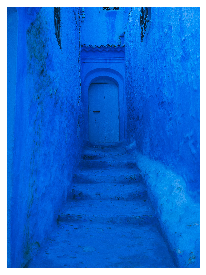

In [44]:
plt.figure(figsize = (20, 10))
show_selected_images(images, COLORS['BLUE'], 60, 5)

FINDING YELLOW COLOR

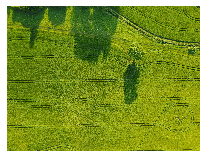

In [45]:
plt.figure(figsize = (20, 10))
show_selected_images(images, COLORS['YELLOW'], 60, 5)